In [1]:
import os
import json
import time
import requests
import random
from pathlib import Path
from typing import List
from IPython.display import IFrame, display_html

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import folium
from folium.plugins import HeatMapWithTime
from geopy.distance import geodesic

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

CITY_CENTER_COORDS = [52.2297, 21.0122]

# Utilities

In [2]:
def get_data(url: str, folder_path: str, file_id: int, api_key: str, headers: dict = {}
            ) -> bool:
    """
    Fetch data from a URL and save it to a file, with handling errors that may occur
    while using the API. Returns True if successful, False otherwise.
    """
    
    try:
        response = requests.post(url, headers=headers)
        
        data = response.json()
        Path(folder_path).mkdir(parents=True, exist_ok=True)
        
        if data.get("result") == "Błędna metoda lub parametry wywołania":
            print(f"An API error occurred: {data['result']}. Status code: {response.status_code}")
            return False
        else:
            save_path = (Path(folder_path, f"data_0{file_id}.json")
                         if file_id < 10
                         else Path(folder_path, f"data_{file_id}.json"))
            
            with open(save_path, "w", encoding="utf-8") as f:
                json.dump(data, f)
            print(f"Data saved successfully to {save_path}")
            return True
    
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
        return False
    except ValueError as json_err:
        print(f"JSON decode error: {json_err}")
        return False
    except Exception as err:
        print(f"An unexpected error occurred: {err}")
        return False


def jsons_to_parquet(folder_path: str, save_filename: str) -> None:
    """Decode and combine all json files in a directory, then save as a parquet file."""
    dataframes = []
    json_files = sorted([file for file in os.listdir(folder_path) if file.endswith(".json")])
    
    for file in json_files:
        with open(Path(folder_path, file), "r", encoding="utf-8") as f:
            data = json.load(f)
            df = pd.json_normalize(data["result"])
            dataframes.append(df)

    all_data = pd.concat(dataframes, ignore_index=True)
    all_data.to_parquet(f"{Path('data', 'parquet', save_filename)}.parquet", engine="pyarrow")


def calculate_distance(data: pd.DataFrame) -> float:
    """Take a vehicle route data and calculate its total distance."""
    total_distance = 0.0
    for i in range(1, len(data)):
        start = (data.iloc[i-1]["Lat"], data.iloc[i-1]["Lon"])
        end = (data.iloc[i]["Lat"], data.iloc[i]["Lon"])
        total_distance += geodesic(start, end).km
        
    return total_distance


def create_distance_df(data: pd.DataFrame) -> pd.DataFrame:
    """Create a dataframe with calculated distance traveled by each vehicle."""
    grouped = data.sort_values(by=["VehicleNumber", "Time"]).groupby(["Lines", "VehicleNumber"])
    distances = grouped.apply(calculate_distance, include_groups=False)
    distances = distances.reset_index(name="TotalDistance")
    
    return distances

# Fetching sample data (every 30 seconds)

12 samples of streetcars data were fetched and saved as json files every 30 second.

This was done twice - in the afternoon and evening, for traffic volume comparison.

In [4]:
api_key = "MY_API_KEY"
url_tram = f"https://api.um.warszawa.pl/api/action/busestrams_get/?resource_id=f2e5503e927d-4ad3-9500-4ab9e55deb59&apikey={api_key}&type=2"
header = {"Cache-Control": "no-cache"}

evening_folder = Path("data", "json", "tram_30s_evening")
afternoon_folder = Path("data", "json", "tram_30s_afternoon")

# # every 30s streetcar data requests (6min)
for i in range(12):
    print(i)
    get_data(url, afternoon_folder, i)
    time.sleep(30)

# Saving and loading data as parquet files

In [5]:
jsons_to_parquet(evening_folder, "tram_30_evening")
jsons_to_parquet(afternoon_folder, "tram_30_afternoon")

parq_folder = Path("data", "parquet")

data_afternoon = pd.read_parquet(Path(parq_folder, "tram_30_afternoon.parquet"))
data_evening = pd.read_parquet(Path(parq_folder, "tram_30_evening.parquet"))

for data in [data_afternoon, data_evening]:
    data.Time = pd.to_datetime(data.Time)

print(data_afternoon.shape, data_evening.shape)
data_afternoon

(6555, 6) (6556, 6)


,Lines,Lon,VehicleNumber,Time,Lat,Brigade
0,36,20.929117,1252,2024-05-23 12:06:19,52.300360,4
1,35,21.006310,1276,2024-06-06 15:17:25,52.213062,014
2,26,20.932413,1282,2024-06-05 14:25:50,52.300140,020
3,4,20.958760,1286,2024-03-28 09:01:54,52.249317,018
4,18,20.928482,1290,2024-06-05 17:21:20,52.300053,015
...,...,...,...,...,...,...
6550,2,20.929567,4281,2024-06-06 15:22:58,52.291920,6
6551,33,20.929977,4282,2024-06-06 15:23:02,52.298847,082
6552,25,20.979330,4283,2024-06-06 15:23:01,52.214085,9
6553,33,20.928213,4284,2024-06-06 15:22:59,52.280228,56


# Distance traveled by vehicles

In [6]:
distances_afternoon = create_distance_df(data_afternoon)
distances_evening = create_distance_df(data_evening)

# outer join because the vehicles run on different lines
distances_merged = distances_afternoon.merge(distances_evening,
                                             on=["Lines", "VehicleNumber"],
                                             how="outer",
                                             suffixes=("_afternoon", "_evening"))

distances_merged

,Lines,VehicleNumber,TotalDistance_afternoon,TotalDistance_evening
0,1,3116,0.687372,NaN
1,1,3123,1.706877,NaN
2,1,3128,NaN,1.282204
3,1,3134,NaN,0.000000
4,1,3138,NaN,0.000000
...,...,...,...,...
816,9,3625,2.377327,NaN
817,9,3639,0.674793,NaN
818,9,3644,NaN,1.644319
819,9,3645,1.760361,NaN


## Distances traveled by vehicles distributions

No surprise, more vehicles are at rest in the evening hours.

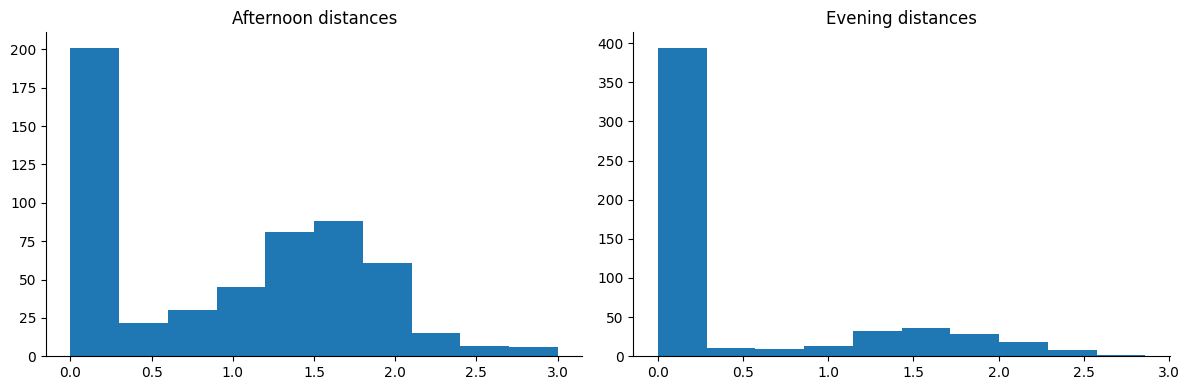

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].hist(distances_merged.TotalDistance_afternoon)
axs[0].set_title("Afternoon distances")
axs[0].spines[["top", "right"]].set_visible(False)
axs[1].hist(distances_merged.TotalDistance_evening)
axs[1].set_title("Evening distances")
axs[1].spines[["top", "right"]].set_visible(False)
plt.tight_layout();

## Distance rank by lines

Sorted by afternoon rank

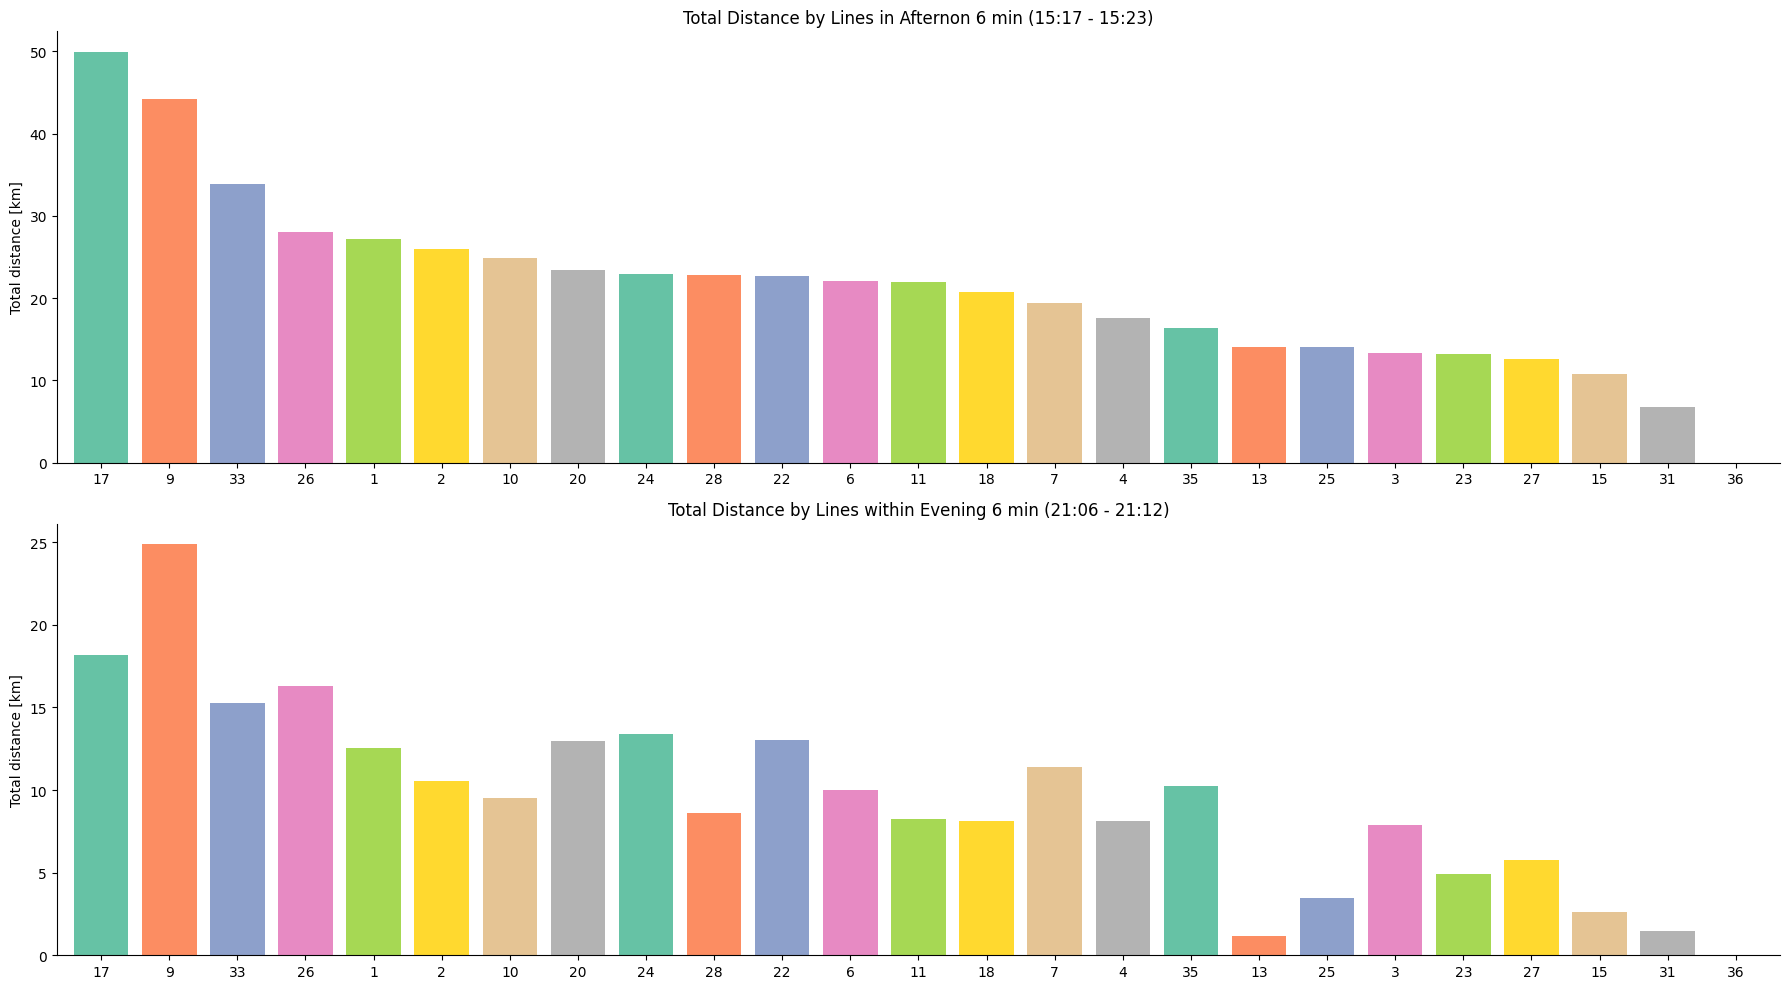

In [32]:
dist_rank = (distances_merged
             .groupby("Lines")[["TotalDistance_afternoon", "TotalDistance_evening"]]
             .sum()
             .sort_values(by="TotalDistance_afternoon", ascending=False))


fig, axes = plt.subplots(2, 1, figsize=(18, 10))

palette = sns.color_palette("Set2")
charts_params = {"xlabel": "", "color": palette,
                 "width": 0.8, "legend": False}

dist_rank.plot.bar(y="TotalDistance_afternoon",
                   ax=axes[0],
                   ylabel="Total distance [km]",
                   **charts_params)
axes[0].ticklabel_format(style="plain", axis="y")
axes[0].set_xticklabels(labels=dist_rank.index, rotation=0)
axes[0].set_title("Total Distance by Lines in Afternon 6 min (15:17 - 15:23)")

dist_rank.plot.bar(y="TotalDistance_evening",
                   ax=axes[1],
                   ylabel="Total distance [km]",
                   **charts_params)
axes[1].set_title("Total Distance by Lines within Evening 6 min (21:06 - 21:12)")
axes[1].set_xticklabels(labels=dist_rank.index, rotation=0)
plt.tight_layout();

# A look at the distribution and routes of vehicles on the map

## Streetcars location in two timestamps

Left map: afternoon (15:17)

Right map: evening (21:06)

In [12]:
maps_folder = Path("data", "maps")

evening_map = folium.Map(location=CITY_CENTER_COORDS, zoom_start=12, width="100%", height="100%")
tooltip = "Click to see the line number!"
for sample in data_evening.groupby("VehicleNumber").first().itertuples():
    folium.Marker([sample.Lat, sample.Lon], 
                   popup=f'<b>{sample.Lines}</b>', 
                   tooltip=tooltip).add_to(evening_map)
evening_map.save(f"{maps_folder}/evening.html")

afternoon_map = folium.Map(location=CITY_CENTER_COORDS, zoom_start=12, width="100%", height="100%")
for sample in data_afternoon.groupby("VehicleNumber").first().itertuples():
    folium.Marker([sample.Lat, sample.Lon], 
                   popup=f"<b>{sample.Lines}</b>", 
                   tooltip=tooltip).add_to(afternoon_map)
afternoon_map.save(f"{maps_folder}/afternoon.html")

# displaying both maps in single row
style = """
<style>
.container {
    display: flex;
    justify-content: space-around;
}
.map {
    width: 50%;
}
</style>
"""

iframe1 = IFrame(src=f"{maps_folder}/afternoon.html", width="99%", height=850)
iframe2 = IFrame(src=f"{maps_folder}/evening.html", width="99%", height=850)

html_content = f"""
<div class="container">
    <div class="map">{iframe1._repr_html_()}</div>
    <div class="map">{iframe2._repr_html_()}</div>
</div>
"""

display_html(style + html_content, raw=True)

## Routes traveled by vehicled during data collecting afternoon period

* 119 of 556 vehicles didn't move while the data was being collected; single entries about them was left
* Routes for moving vehicles and markers for stagnant vehicled were plotted on Warsaw map

In [13]:
filtered_afternoon = data_afternoon.drop_duplicates(subset=["VehicleNumber", "Lon", "Lat"])
counts = filtered_afternoon.VehicleNumber.value_counts()

moving = counts[counts > 1].index.tolist()
stagnant = counts[counts == 1].index.tolist()

afternoon_moving = filtered_afternoon[filtered_afternoon['VehicleNumber'].isin(moving)].sort_values(by=["VehicleNumber", "Time"])
afternoon_stagnant = filtered_afternoon[filtered_afternoon['VehicleNumber'].isin(stagnant)].sort_values(by=["VehicleNumber", "Time"])

len(moving), len(stagnant)

(430, 119)

In [14]:
afternoon_moving

,Lines,Lon,VehicleNumber,Time,Lat,Brigade
1,35,21.006310,1276,2024-06-06 15:17:25,52.213062,014
548,35,21.005510,1276,2024-06-06 15:17:55,52.215620,014
1094,35,21.005226,1276,2024-06-06 15:18:25,52.216750,014
1640,35,21.005243,1276,2024-06-06 15:18:56,52.216740,014
2186,35,21.005026,1276,2024-06-06 15:19:31,52.217890,014
...,...,...,...,...,...,...
4368,17,20.929735,4285,2024-06-06 15:20:51,52.291900,7
4915,17,20.929703,4285,2024-06-06 15:21:21,52.291910,7
5462,17,20.929705,4285,2024-06-06 15:21:52,52.291910,7
6008,17,20.929705,4285,2024-06-06 15:22:27,52.291904,7


In [15]:
colors = random.sample(list(mcolors.CSS4_COLORS.keys()), afternoon_moving.Lines.nunique())

routes_map = folium.Map(location=CITY_CENTER_COORDS, zoom_start=12, tiles="cartodb positron")
tooltip = "Click to see line and vehicle number!"

for idx, line in enumerate(afternoon_moving.Lines.unique()):
    data = afternoon_moving[afternoon_moving.Lines == line]
    color = colors[idx]
    
    for vehicle in data.VehicleNumber.unique():
        coordinates = [[coords.Lat, coords.Lon] for coords in data[data.VehicleNumber == vehicle].itertuples()]
        
        # adding route and circle markers at the start and the end
        folium.PolyLine(locations=coordinates,
                        color=color,
                        tooltip=tooltip,
                        popup=f"<b>Line: {line}, Vehicle: {vehicle}</b>").add_to(routes_map)
        
        folium.CircleMarker(location=coordinates[0],
                            radius=3,
                            tooltip="start",
                            color=color).add_to(routes_map)
        
        folium.CircleMarker(location=coordinates[-1],
                            radius=3,
                            tooltip="end",
                            color=color).add_to(routes_map)

# adding circle markers for stagnant vehicles
for vehicle in afternoon_stagnant.itertuples():
    folium.CircleMarker([vehicle.Lat, vehicle.Lon],
                         radius=5, fill=True,
                         popup=f"<b>Line: {vehicle.Lines}, Vehicle: {vehicle.VehicleNumber}</b>", 
                         tooltip=f"This one didn't move!\n{tooltip}").add_to(routes_map)

title_html = '''
<div style="position: fixed; 
     top: 10px; right: 10px; width: auto; height: auto; 
     z-index:9999; font-size:24px; font-weight: bold;
     color: black; text-align: right; padding: 10px;">
     Warsaw streetcars, 2024-06-06, 15:17:25-15:22:58
</div>
'''
routes_map.get_root().html.add_child(folium.Element(title_html))

routes_map.save(f"{maps_folder}/routes.html")
routes_map

# Checking bus traffic volume during the day

The data was collected about every 5 minutes from 5AM to 9AM and the time data has been normalized to 30-minute intervals.\
So this is not a very accurate picture, just a way of showing; in addition, in the case of bus data, it often failed to download the correct data from the API. 

Nevertheless, you can see the change in vehicle density at different times.

In [16]:
bus_folder = Path("data", "json", "bus_5min")
url_bus = f"https://api.um.warszawa.pl/api/action/busestrams_get/?resource_id=f2e5503e927d-4ad3-9500-4ab9e55deb59&apikey={api_key}&type=1"

# every 5min requests with additional control output and retrials due to issues with retrieving bus data
for i in range(48):
    print(f"Attempting to fetch data for file_id: {i}")
    while not get_data(url_bus, bus_folder, i, api_key):
        print(f"Retrying in 30s for file_id: {i}")
        time.sleep(30)
    print("....") if i < 47 else print("Done")
    time.sleep(60*5)

In [17]:
parq_folder = Path("data", "parquet")
bus_folder = Path("data", "json", "bus_5min")

jsons_to_parquet(bus_folder, "buses")

data = pd.read_parquet(Path(parq_folder, "buses.parquet"))
data.Time = pd.to_datetime(data.Time, format="ISO8601").dt.floor("30min")
data = data[(data.Time >= "2024-06-10 05:00:00") & (data.Time <= "2024-06-10 09:00:00")]

# filtering stagnant vehicles
filtered_data = data.drop_duplicates(subset=["VehicleNumber", "Lon", "Lat"], keep=False)
counts = filtered_data.VehicleNumber.value_counts()
moving_vehicles = counts[counts > 1].index.tolist()

moving = filtered_data[filtered_data["VehicleNumber"].isin(moving_vehicles)].sort_values(by=["Time", "VehicleNumber", ])
moving

,Lines,Lon,VehicleNumber,Time,Lat,Brigade
0,219,21.168723,1000,2024-06-10 05:00:00,52.199145,3
1843,219,21.140830,1000,2024-06-10 05:00:00,52.190199,3
3688,219,21.168193,1000,2024-06-10 05:00:00,52.184375,3
5533,219,21.187780,1000,2024-06-10 05:00:00,52.183945,3
7379,219,21.170545,1000,2024-06-10 05:00:00,52.184204,3
...,...,...,...,...,...,...
86698,186,20.954885,9954,2024-06-10 09:00:00,52.264297,12
88540,186,20.953423,9954,2024-06-10 09:00:00,52.263008,12
84858,114,20.932484,9955,2024-06-10 09:00:00,52.295311,6
86699,114,20.931389,9955,2024-06-10 09:00:00,52.289864,6


In [22]:
heat_data = []
time_stamps = []

for timestamp, group in moving.groupby("Time"):
    time_data = []
    for lat, lon in zip(group['Lat'], group['Lon']):
        time_data.append([lat, lon])
    heat_data.append(time_data)
    time_stamps.append(timestamp.strftime('%Y-%m-%d %H:%M:%S'))

hm = folium.Map(location=CITY_CENTER_COORDS,
                tiles='cartodbpositron',
                zoom_start=12)

# adding HeatMapWithTime layer
HeatMapWithTime(heat_data,
                index=time_stamps,
                name="HeatMap",
                radius=20,
                blur=0.9,
                auto_play=True).add_to(hm)
folium.LayerControl().add_to(hm)

title_html = '''
<div style="position: fixed; 
     top: 10px; right: 10px; width: auto; height: auto; 
     z-index:9999; font-size:24px; font-weight: bold;
     color: black; text-align: right; padding: 10px;">
     Warsaw bus traffic, 2024-06-10, 5AM-9AM
</div>
'''
hm.get_root().html.add_child(folium.Element(title_html))

hm.save(f"{maps_folder}/heatmap_with_time.html")
hm